In [1]:
import pandas as pd
import numpy as np
import requests
import zipfile
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [2]:
# Getting the data 1
url = 'https://archive.ics.uci.edu/static/public/222/bank+marketing.zip'
dataset_path = '../datasets/'
dataset_file = 'bank+marketing.zip'
dataset_full_path = os.path.join(dataset_path, dataset_file)
response = requests.get(url)
with open(f'{dataset_path}bank+marketing.zip', 'wb') as file:
    for chunk in response.iter_content(chunk_size=1024):
        file.write(chunk)

with zipfile.ZipFile(f'{dataset_path}bank+marketing.zip') as zip_ref:
    zip_ref.extractall(f'{dataset_path}/bank+marketing')

with zipfile.ZipFile(f'{dataset_path}/bank+marketing/bank.zip') as zip_ref:
    zip_ref.extractall(f'{dataset_path}/bank+marketing')

In [3]:
bank = pd.read_csv(f'{dataset_path}/bank+marketing/bank-full.csv', sep=';')

In [4]:
df = bank[
    ['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month', 'duration', 'campaign',
     'pdays', 'previous', 'poutcome', 'y']]

In [5]:
df.loc[:, 'y'] = df['y'].map({'yes': 1, 'no': 0})

In [6]:
# Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1
df_full_train, df_test = train_test_split(df, test_size=0.19999, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.24999, random_state=1)
len(df), len(df_full_train), len(df_train), len(df_test), len(df_val)

(45211, 36169, 27127, 9042, 9042)

In [7]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [8]:
y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

del df_train['y']
del df_val['y']
del df_test['y']

In [9]:
numerical = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
categorical = ['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']

In [10]:
# Question 1: ROC AUC feature importance
# ROC AUC could also be used to evaluate feature importance of numerical variables.
# 
# Let's do that
# 
# For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
# Use the training dataset for that
# If your AUC is < 0.5, invert this variable by putting "-" in front
# 
# (e.g. -df_train['engine_hp'])
# 
# AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.
# 
# Which numerical variable (among the following 4) has the highest AUC?
# 
# balance
# day
# duration
# previous


In [11]:
def train_logistic_regression(features, df_train, y_train, C=1.0):
    dv = DictVectorizer(sparse=False)
    dict = df_train[features].to_dict(orient='records')
    X_train = dv.fit_transform(dict)
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    return dv, model

In [12]:
def predict_logistic_regression(features, df, dv, model):
    dict = df[features].to_dict(orient='records')
    X_val = dv.transform(dict)
    y_pred = model.predict_proba(X_val)[:, 1]
    return y_pred

In [13]:
y_train = y_train.astype('int')
y_val = y_val.astype('int')

In [14]:
all_features = categorical + numerical
all_without_balance = list(filter(lambda x: 'balance' not in x, all_features))
all_without_day = list(filter(lambda x: 'day' not in x, all_features))
all_without_duration = list(filter(lambda x: 'duration' not in x, all_features))
all_without_previous = list(filter(lambda x: 'previous' not in x, all_features))

In [15]:
y_train = y_train.astype('int')
y_val = y_val.astype('int')
features = all_without_balance

dv, model = train_logistic_regression(features, df_train, y_train, C=0.001)
y_pred = predict_logistic_regression(features, df_val, dv, model)
roc_auc_score(y_val, y_pred)

np.float64(0.8589689245032855)

In [16]:
y_train = y_train.astype('int')
y_val = y_val.astype('int')
features = all_without_day

dv, model = train_logistic_regression(features, df_train, y_train, C=0.001)
y_pred = predict_logistic_regression(features, df_val, dv, model)
roc_auc_score(y_val, y_pred)

np.float64(0.8560180346272586)

In [17]:
y_train = y_train.astype('int')
y_val = y_val.astype('int')
features = all_without_duration

dv, model = train_logistic_regression(features, df_train, y_train, C=0.001)
y_pred = predict_logistic_regression(features, df_val, dv, model)
roc_auc_score(y_val, y_pred)

np.float64(0.7219632194253308)

In [18]:
y_train = y_train.astype('int')
y_val = y_val.astype('int')
features = all_without_previous

dv, model = train_logistic_regression(features, df_train, y_train, C=0.001)
y_pred = predict_logistic_regression(features, df_val, dv, model)
roc_auc_score(y_val, y_pred)

np.float64(0.8588513389271163)

In [19]:
# Question 2: Training the model
# Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:
# 
# LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
# What's the AUC of this model on the validation dataset? (round to 3 digits)
# 
# 0.69
# 0.79
# 0.89
# 0.99

In [20]:
y_train = y_train.astype('int')
y_val = y_val.astype('int')
features = all_features

dv, model = train_logistic_regression(features, df_train, y_train)
y_pred = predict_logistic_regression(features, df_val, dv, model)
roc_auc_score(y_val, y_pred).round(3)

np.float64(0.904)

In [21]:
# Question 3: Precision and Recall
# Now let's compute precision and recall for our model.
# 
# Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
# For each threshold, compute precision and recall
# Plot them
# At which threshold precision and recall curves intersect?
# 
# 0.265
# 0.465
# 0.665
# 0.865

In [22]:
def precision_recall_df(y_true, y_pred):
    scores = []
    thresholds = np.linspace(0, 1, 101)
    for t in thresholds:
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        precision = tp / (tp + fp) if (tp + fp) > 0 else float('nan')
        recall = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
        f1 = 2 * ((precision * recall) / (precision + recall))

        scores.append((t, tp, fp, tn, fn, precision, recall, f1))

    columns = ["thresholds", "tp", "fp", "tn", "fn", "precision", "recall", "f1"]
    df_scores = pd.DataFrame(scores, columns=columns)
    return df_scores

In [23]:
df_plot = precision_recall_df(y_val, y_pred)
df_plot

,thresholds,tp,fp,tn,fn,precision,recall,f1
0,0.00,1032,8010,0,0,0.114134,1.000000,0.204884
1,0.01,1028,7078,932,4,0.126820,0.996124,0.224995
2,0.02,1025,5887,2123,7,0.148293,0.993217,0.258056
3,0.03,1019,4808,3202,13,0.174876,0.987403,0.297128
4,0.04,1011,3930,4080,21,0.204614,0.979651,0.338523
...,...,...,...,...,...,...,...,...
96,0.96,23,17,7993,1009,0.575000,0.022287,0.042910
97,0.97,18,14,7996,1014,0.562500,0.017442,0.033835
98,0.98,15,10,8000,1017,0.600000,0.014535,0.028382
99,0.99,6,9,8001,1026,0.400000,0.005814,0.011461


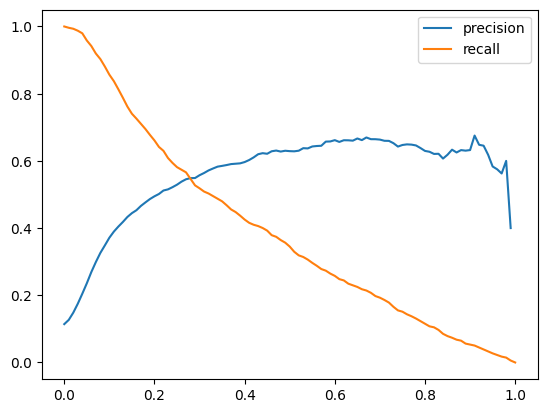

In [24]:
plt.plot(df_plot.thresholds, df_plot['precision'], label='precision')
plt.plot(df_plot.thresholds, df_plot['recall'], label='recall')
plt.legend()

In [25]:
# Question 4: F1 score
# Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both
# 
# At which threshold F1 is maximal?
# 
# 0.02
# 0.22
# 0.42
# 0.62

In [26]:
df_plot[['thresholds', 'f1']].sort_values(by='f1', ascending=False, inplace=False).iloc[:5]

,thresholds,f1
19,0.19,0.566221
20,0.20,0.565740
18,0.18,0.565235
22,0.22,0.564726
21,0.21,0.562925


In [27]:
# Question 5: 5-Fold CV
# Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:
# 
# KFold(n_splits=5, shuffle=True, random_state=1)
# Iterate over different folds of df_full_train
# Split the data into train and validation
# Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
# Use AUC to evaluate the model on validation
# How large is standard deviation of the scores across different folds?
# 
# 0.0001
# 0.006
# 0.06
# 0.26

In [28]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [29]:
def train_logistic_regression1(df_t, y_t, C=1.0):
    dv = DictVectorizer(sparse=False)
    dict = df_t[categorical + numerical].to_dict(orient='records')
    X_train = dv.fit_transform(dict)
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_t)
    return dv, model


def predict_logistic_regression1(df, dv, model):
    dict = df[categorical + numerical].to_dict(orient='records')
    X_val = dv.transform(dict)
    y_pred = model.predict_proba(X_val)[:, 1]
    return y_pred

In [30]:
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train1 = df_full_train.iloc[train_idx]
    df_val1 = df_full_train.iloc[val_idx]

    y_train1 = df_train1.y.values
    y_val1 = df_val1.y.values

    y_train1 = y_train1.astype('int')
    y_val1 = y_val1.astype('int')
    # 
    dv, model = train_logistic_regression1(df_train1, y_train1)
    y_pred = predict_logistic_regression1(df_val1, dv, model)
    auc = roc_auc_score(y_val1, y_pred)
    scores.append(auc)

In [31]:
scores

[np.float64(0.9050960044828757),
 np.float64(0.9054116036446404),
 np.float64(0.9043435372830548),
 np.float64(0.9067046710994654),
 np.float64(0.9089011200735105)]

In [32]:
np.mean(scores), np.std(scores)
print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.906 +- 0.002


In [33]:
# Question 6: Hyperparameter Tuning
# Now let's use 5-Fold cross-validation to find the best parameter C
# 
# Iterate over the following C values: [0.000001, 0.001, 1]
# Initialize KFold with the same parameters as previously
# Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
# Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
# Which C leads to the best mean score?
# 
# 0.000001
# 0.001
# 1


In [34]:

for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train1 = df_full_train.iloc[train_idx]
        df_val1 = df_full_train.iloc[val_idx]

        y_train1 = df_train1.y.values
        y_val1 = df_val1.y.values

        y_train1 = y_train1.astype('int')
        y_val1 = y_val1.astype('int')
        # 
        dv, model = train_logistic_regression1(df_train1, y_train1, C)
        y_pred = predict_logistic_regression1(df_val1, dv, model)
        auc = roc_auc_score(y_val1, y_pred)
        scores.append(auc)
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/3 [00:00<?, ?it/s]

C=1e-06 0.701 +- 0.011
C=0.001 0.861 +- 0.005
C=1 0.906 +- 0.002
